In [1]:
import numpy as np
import pandas as pd
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from mllib.params import FieldNames, FileNames
from mllib.utils import load_pickle
from mllib.transformers import ListLen, SetLen, ListAggregation

In [2]:
def make_x_y(x_tr, x_val, flag='val'):
    y_tr = x_tr['redemption_status'].values

    if flag == 'val':
        y_val = x_val['redemption_status'].values
    else:
        y_val = None
    return x_tr, y_tr, x_val, y_val


def get_rank_features(df):
    df['cust_coupon_rank1'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_0'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank2'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_1'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank3'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_2'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank4'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_0'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank5'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_1'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank6'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_2'].rank('max')/df['customer_campaign_count']

    df['customer_rank1'] = df.groupby(['customer_id'])['common_item_set_0'].rank('max')/df.groupby('customer_id').size()
    df['customer_rank2'] = df.groupby(['customer_id'])['common_brand_0'].rank('max')/df.groupby('customer_id').size()
    df['customer_rank3'] = df.groupby(['customer_id'])['common_category_0'].rank('max')/df.groupby('customer_id').size()

    # df['customer_rank4'] = df.groupby(['customer_id'])['common_brand_1'].rank('max')/df.groupby('customer_id').size()
    # df['customer_rank3'] = df.groupby(['customer_id'])['common_item_set_2'].rank('max')/df.groupby('customer_id').size()
    df['campaign_rank1'] = df.groupby(['campaign_id'])['common_item_set_0'].rank('max')/df.groupby('campaign_id').size()
    df['campaign_rank2'] = df.groupby(['campaign_id'])['common_brand_0'].rank('max')/df.groupby('campaign_id').size()

    #df['campaign_rank2'] = df.groupby(['campaign_id'])['common_item_set_1'].rank('max')/df.groupby('campaign_id').size()
    #df['campaign_rank3'] = df.groupby(['campaign_id'])['common_item_set_2'].rank('max')/df.groupby('campaign_id').size()
    #df['coupon_rank1'] = df.groupby(['coupon_id'])['common_item_set_0'].rank('max')/df.groupby('coupon_id').size()
    df['coupon_rank1'] = df.groupby(['coupon_id'])['common_brand_0'].rank('max')/df.groupby('coupon_id').size()
    #df['coupon_rank2'] = df.groupby(['coupon_id'])['common_category_0'].rank('max')/df.groupby('coupon_id').size()
    #df['coupon_rank2'] = df.groupby(['coupon_id'])['common_item_set_1'].rank('max')/df.groupby('coupon_id').size()

    return df


def load_data(flag='val'):
    if flag == 'val':
        x_tr = load_pickle(FileNames.tr_features_v3)
        x_val = load_pickle(FileNames.val_features_v3)
    elif flag == 'test':
        x_tr = load_pickle(FileNames.train_features_v3)
        x_val = load_pickle(FileNames.test_features_v3)
    
    return make_x_y(x_tr, x_val, flag=flag)


def map_campign_id(x_tr, x_val, flag='val'):
    if flag == 'val':
        tr = load_pickle(FileNames.tr_v2)
        val = load_pickle(FileNames.val_v2)
    elif flag == 'test':
        tr = load_pickle(FileNames.train_v2)
        val = load_pickle(FileNames.test_v2)
        
    x_tr['campaign_id'] = tr['campaign_id'].values
    x_val['campaign_id'] = val['campaign_id'].values
    return x_tr, x_val

In [3]:
from mllib.targetencoder import TargetEncoderWithThresh

In [4]:
x_tr, y_tr, x_val, y_val = load_data('val')
x_tr, x_val = map_campign_id(x_tr, x_val, 'val')

In [5]:
n_feats = x_tr.shape[1] - 1
n_feats

387

In [6]:
x_tr = get_rank_features(x_tr)
x_val = get_rank_features(x_val)

In [7]:
y_tr = y_tr[x_tr.coupon_id != 8]
x_tr = x_tr.loc[x_tr.coupon_id != 8]


In [8]:
x_tr['common_brand_0'] = x_tr['common_brand_0']/len(x_tr)
x_val['common_brand_0'] = x_val['common_brand_0']/(len(x_tr) + len(x_val))

x_tr['common_item_set_0'] = x_tr['common_item_set_0']/len(x_tr)
x_val['common_item_set_0'] = x_val['common_item_set_0']/(len(x_tr) + len(x_val))

In [10]:
lgb_params = {
    "n_estimators": 100000,
    "boosting_type": "gbdt",
    "num_leaves": 3,
    "max_depth": 2,
    "colsample_bytree": 0.45,
    "metric": None,
    "subsample": 0.66,
    "learning_rate": 0.0043,
    "reg_lambda": 1.66,
    "reg_alpha": 3e-5,
    "min_data_in_leaf": 669,
    "min_child_samples": 200,
    "max_bin": 255,
    "cat_smooth": 50,
    "max_cat_threshold": 32,
    "cat_l2": 50,
    "seed": 6341,
    "allow_nan": True
}
model = lgb.LGBMClassifier(**lgb_params)

feats = [
    f
    for i, f in enumerate(x_tr.columns)
    if ("coupon_details" not in f)
    and ("common_repeats" not in f)
    and (
        f not in ["campaign_id", "customer_campaign_count", "redemption_status"]
    )
]

model.fit(x_tr[feats], y_tr, eval_set=[(x_tr[feats], y_tr), (x_val[feats], y_val)],
          eval_metric='auc', verbose=50, early_stopping_rounds=1000) 
val_preds = model.predict_proba(x_val[feats])[:, 1]

Training until validation scores don't improve for 1000 rounds
[50]	valid_0's auc: 0.897356	valid_1's auc: 0.907888
[100]	valid_0's auc: 0.900949	valid_1's auc: 0.911954
[150]	valid_0's auc: 0.902191	valid_1's auc: 0.913071
[200]	valid_0's auc: 0.905332	valid_1's auc: 0.915849
[250]	valid_0's auc: 0.907979	valid_1's auc: 0.917378
[300]	valid_0's auc: 0.91119	valid_1's auc: 0.919229
[350]	valid_0's auc: 0.913004	valid_1's auc: 0.920549
[400]	valid_0's auc: 0.915672	valid_1's auc: 0.922387
[450]	valid_0's auc: 0.917363	valid_1's auc: 0.924172
[500]	valid_0's auc: 0.919907	valid_1's auc: 0.926611
[550]	valid_0's auc: 0.921658	valid_1's auc: 0.92844
[600]	valid_0's auc: 0.92285	valid_1's auc: 0.929543
[650]	valid_0's auc: 0.924026	valid_1's auc: 0.930705
[700]	valid_0's auc: 0.924942	valid_1's auc: 0.931706
[750]	valid_0's auc: 0.926121	valid_1's auc: 0.933062
[800]	valid_0's auc: 0.927239	valid_1's auc: 0.934223
[850]	valid_0's auc: 0.928178	valid_1's auc: 0.935123
[900]	valid_0's auc: 0.

In [11]:
x_train, y_train, x_test, _ = load_data('test')
x_train, x_test = map_campign_id(x_train, x_test, 'test')
x_train = get_rank_features(x_train)
x_test = get_rank_features(x_test)

#train = load_pickle(FileNames.train_v2)
#test = load_pickle(FileNames.test_v2)
#hist_artifact = load_pickle(FileNames.cust_train_artifact1)
#x_tr = map_brand_categories(x_tr, tr, hist_artifact)
#x_val = map_brand_categories(x_val, val, hist_artifact)

y_train = y_train[x_train.coupon_id != 8]
x_train = x_train.loc[x_train.coupon_id != 8]

x_train['common_brand_0'] = x_train['common_brand_0']/len(x_train)
x_test['common_brand_0'] = x_test['common_brand_0']/(len(x_train) + len(x_test))

x_train['common_item_set_0'] = x_train['common_item_set_0']/len(x_train)
x_test['common_item_set_0'] = x_test['common_item_set_0']/(len(x_train) + len(x_test))
#cvlist = StratifiedKFold(10, random_state=123).split(x_tr, y_tr)
#x_tr['cust_trenc'] = cross_val_predict(trenc, x_tr, y_tr, cv=cvlist, n_jobs=-1, method='transform')
#x_val['cust_trenc'] = trenc.fit(x_tr).transform(x_val)

In [12]:
lgb_params['n_estimators'] = 5500
model = lgb.LGBMClassifier(**lgb_params)

model.fit(x_train[feats], y_train, eval_set=[(x_train[feats], y_train)], eval_metric='auc', verbose=50)
test_preds = model.predict_proba(x_test[feats])[:, 1]

[50]	valid_0's auc: 0.907743
[100]	valid_0's auc: 0.909818
[150]	valid_0's auc: 0.912461
[200]	valid_0's auc: 0.917506
[250]	valid_0's auc: 0.919677
[300]	valid_0's auc: 0.921925
[350]	valid_0's auc: 0.923645
[400]	valid_0's auc: 0.925198
[450]	valid_0's auc: 0.926268
[500]	valid_0's auc: 0.928799
[550]	valid_0's auc: 0.930603
[600]	valid_0's auc: 0.932293
[650]	valid_0's auc: 0.933244
[700]	valid_0's auc: 0.934156
[750]	valid_0's auc: 0.934915
[800]	valid_0's auc: 0.935808
[850]	valid_0's auc: 0.936435
[900]	valid_0's auc: 0.937012
[950]	valid_0's auc: 0.937472
[1000]	valid_0's auc: 0.937934
[1050]	valid_0's auc: 0.938374
[1100]	valid_0's auc: 0.93891
[1150]	valid_0's auc: 0.939329
[1200]	valid_0's auc: 0.939691
[1250]	valid_0's auc: 0.940038
[1300]	valid_0's auc: 0.940388
[1350]	valid_0's auc: 0.940637
[1400]	valid_0's auc: 0.940965
[1450]	valid_0's auc: 0.941266
[1500]	valid_0's auc: 0.941572
[1550]	valid_0's auc: 0.941836
[1600]	valid_0's auc: 0.942114
[1650]	valid_0's auc: 0.94240

/home/mohsin/kg7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


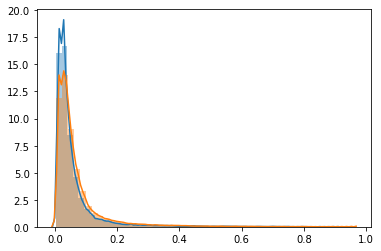

In [13]:
sns.distplot(np.sqrt(val_preds))
sns.distplot(np.sqrt(test_preds))

In [14]:
test = pd.read_csv('data/test.csv')
sub = test[['id']]
sub['redemption_status'] = test_preds
sub.head()

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,redemption_status
0,3,0.320637
1,4,0.009584
2,5,0.012611
3,8,0.000650
4,10,0.000688


In [15]:
sub.to_csv('data/sub_model15.csv', index=False)

In [16]:
sube3 = pd.read_csv('data/sub_en4.csv')
sub1 = pd.read_csv('data/sub_model8.csv')

In [17]:
sub2 =pd.read_csv('data/sub_model9.csv')

In [18]:
#sub = sub1['redemption_status']* + sube1['redemption_status']*

In [19]:
from scipy.stats import spearmanr

In [20]:
#spearmanr(test_preds, tmp.redemption_status)

In [21]:
spearmanr(test_preds, sub1.redemption_status)

SpearmanrResult(correlation=0.9770246335401086, pvalue=0.0)

In [22]:
spearmanr(test_preds, sub2.redemption_status)

SpearmanrResult(correlation=0.9797010564945849, pvalue=0.0)

In [23]:
spearmanr(test_preds, sube3.redemption_status)

SpearmanrResult(correlation=0.9922114782790058, pvalue=0.0)

In [24]:
from scipy.stats import gmean
sub = test[['id']]
sub['redemption_status'] = gmean([test_preds, sube3['redemption_status']])
sub.head()

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,redemption_status
0,3,0.373857
1,4,0.011624
2,5,0.010931
3,8,0.000746
4,10,0.000748


In [25]:
sub.to_csv('data/sub_en5.csv', index=False)